In [1]:
import sys
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import balanced_accuracy_score, accuracy_score, matthews_corrcoef
from sklearn.model_selection import GridSearchCV

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn.svm import SVC

sys.path.append("../../")

from helpers.split import tag_label_feature_split
from helpers.assess import make_classification_report, make_confusion_matrix

DATASET_FOLDER = "../../datasets/"

In [2]:
# read a data set
dataset="dataset_00_all.pickle"
df = pd.read_pickle(DATASET_FOLDER + dataset)

In [3]:
# get labels, a label encoder and features
_, (y, le), X = tag_label_feature_split(df, label_format="encoded")

In [4]:
# undersample to create balanced dataset
rus = RandomUnderSampler(random_state=1962)
X_res, y_res = rus.fit_resample(X, y)

In [5]:
# confirm the number of samples of each class
np.unique(y_res, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([361, 361, 361, 361, 361, 361, 361, 361, 361, 361]))

In [6]:
# split into train/validation and test datasets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_res, y_res, test_size=0.2, shuffle=True, stratify=y_res, random_state=1962
)

In [7]:
# split training/validation into training and validation datasets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, shuffle=True, stratify=y_train_val, random_state=1962
)

In [8]:
# standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [10]:
pca=PCA(random_state=1962, n_components=.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [11]:
param_grid = [
  {'C': [1, 10, 100, 1000],
   'gamma': [0.001, 0.0001],
   'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
   'random_state': [1962]
  }]

grid = GridSearchCV(SVC(), param_grid, scoring='matthews_corrcoef', n_jobs=-1, verbose=4)
grid.fit(X_train_pca, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'random_state': [1962]}],
             scoring='matthews_corrcoef', verbose=4)

In [12]:
grid.best_score_

0.5538088004931845

In [13]:
grid.best_params_

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf', 'random_state': 1962}

In [14]:
param_grid = [
  {'C': [1, 10, 100, 1000],
   'gamma': [0.001, 0.0001],
   'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
   'random_state': [1962]
  }]

grid_2 = GridSearchCV(SVC(), param_grid, scoring='matthews_corrcoef', n_jobs=-1, verbose=4)
grid_2.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'random_state': [1962]}],
             scoring='matthews_corrcoef', verbose=4)

In [15]:
print(grid_2.best_score_)
print(grid_2.best_params_)

0.5542814459984954
{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf', 'random_state': 1962}


**Without PCA**

In [18]:
classifier=SVC(C=10, kernel='rbf', gamma =.0001, random_state=1962)

In [20]:
classifier.fit(X_train_scaled, y_train)

SVC(C=10, gamma=0.0001, random_state=1962)

In [21]:
predictions=classifier.predict(X_test_scaled)

In [22]:
classifier.score(X_test_scaled, y_test)

0.6121883656509696

In [23]:
balanced_accuracy_score(y_test, predictions)

0.612709284627093

In [24]:
matthews_corrcoef(y_test, predictions)

0.5697563428220399

In [26]:
make_classification_report(
    y_true=y_test,
    y_pred=predictions,
    model=classifier,
    x = X_test_scaled,
    label_encoder=le,
    print_report=True
)
pass

                   precision  recall  f1-score  support   mcc
                                                             
      genre_blues       0.47    0.50      0.49       72  0.43
  genre_classical       0.67    0.81      0.73       72  0.71
    genre_country       0.76    0.53      0.63       73  0.61
      genre_disco       0.68    0.68      0.68       72  0.65
     genre_hiphop       0.69    0.60      0.64       72  0.61
       genre_jazz       0.56    0.65      0.60       72  0.56
      genre_metal       0.76    0.76      0.76       72  0.74
        genre_pop       0.35    0.32      0.33       73  0.26
     genre_reggae       0.68    0.75      0.72       72  0.68
       genre_rock       0.51    0.53      0.52       72  0.47
                                                             
         accuracy                         0.61      722  0.57
        macro avg       0.62    0.61      0.61      722      
     weighted avg       0.62    0.61      0.61      722      
        

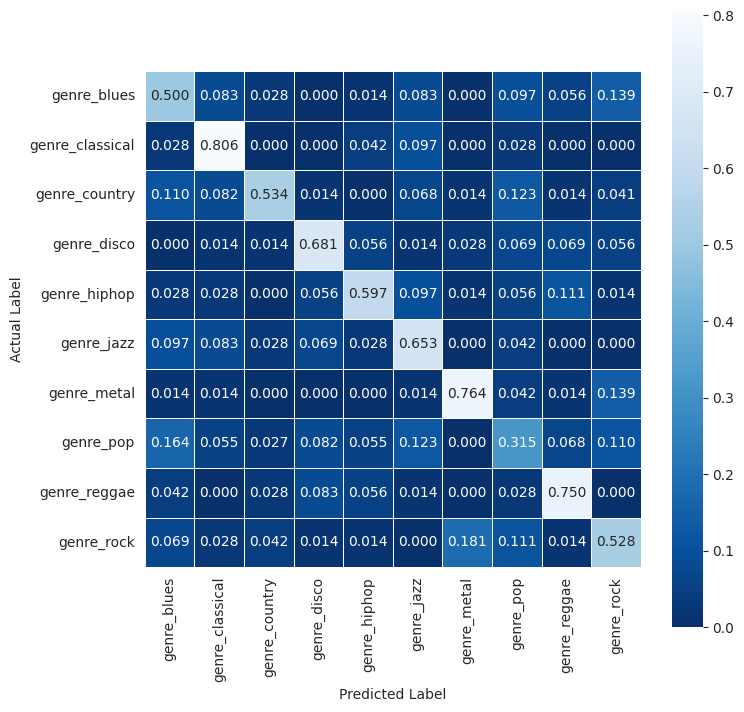

In [29]:
make_confusion_matrix(
    y_true=y_test,
    y_pred=predictions,
    model=classifier,
    x = X_test,
    normalize="true",  
    autoweight_sample=True,  
    label_encoder=le,  
    figsize=(8, 8),  
)
pass

**With PCA**

In [30]:
classifier_PCA=SVC(C=10, kernel='rbf', gamma =.0001, random_state=1962)

In [31]:
classifier_PCA.fit(X_train_pca, y_train)

SVC(C=10, gamma=0.0001, random_state=1962)

In [32]:
predictions_PCA=classifier_PCA.predict(X_test_pca)

In [33]:
classifier_PCA.score(X_test_pca, y_test)

0.6011080332409973

In [34]:
balanced_accuracy_score(y_test, predictions_PCA)

0.6016362252663623

In [35]:
matthews_corrcoef(y_test, predictions_PCA)

0.5575738279059834

In [36]:
make_classification_report(
    y_true=y_test,
    y_pred=predictions,
    model=classifier_PCA,
    x = X_test_pca,
    label_encoder=le,
    print_report=True
)
pass

                   precision  recall  f1-score  support   mcc
                                                             
      genre_blues       0.47    0.50      0.49       72  0.43
  genre_classical       0.67    0.81      0.73       72  0.71
    genre_country       0.76    0.53      0.63       73  0.61
      genre_disco       0.68    0.68      0.68       72  0.65
     genre_hiphop       0.69    0.60      0.64       72  0.61
       genre_jazz       0.56    0.65      0.60       72  0.56
      genre_metal       0.76    0.76      0.76       72  0.74
        genre_pop       0.35    0.32      0.33       73  0.26
     genre_reggae       0.68    0.75      0.72       72  0.68
       genre_rock       0.51    0.53      0.52       72  0.47
                                                             
         accuracy                         0.61      722  0.57
        macro avg       0.62    0.61      0.61      722      
     weighted avg       0.62    0.61      0.61      722      
        

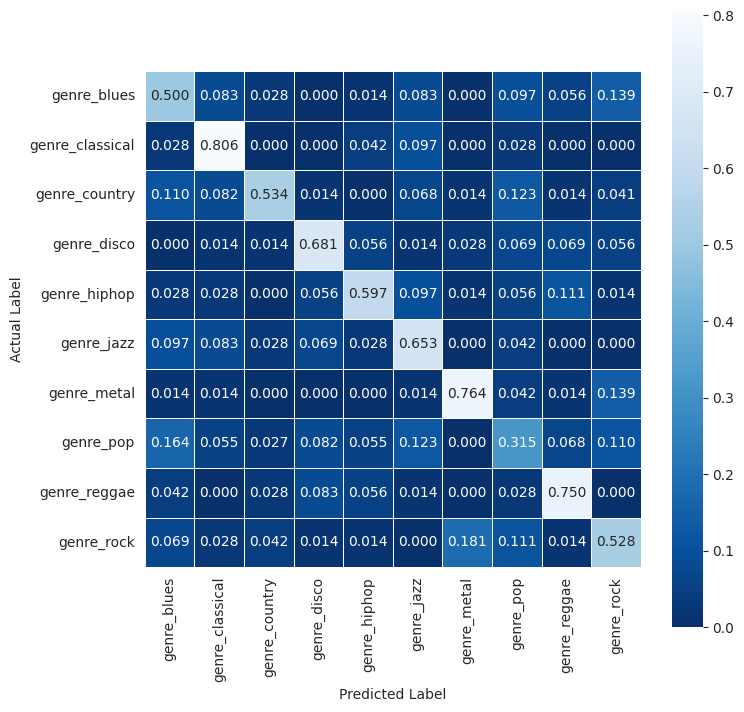

In [37]:
make_confusion_matrix(
    y_true=y_test,
    y_pred=predictions,
    model=classifier_PCA,
    x = X_test_pca,
    normalize="true",  
    autoweight_sample=True,  
    label_encoder=le,  
    figsize=(8, 8),  
)
pass

**Plot Learning Curve**

In [43]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


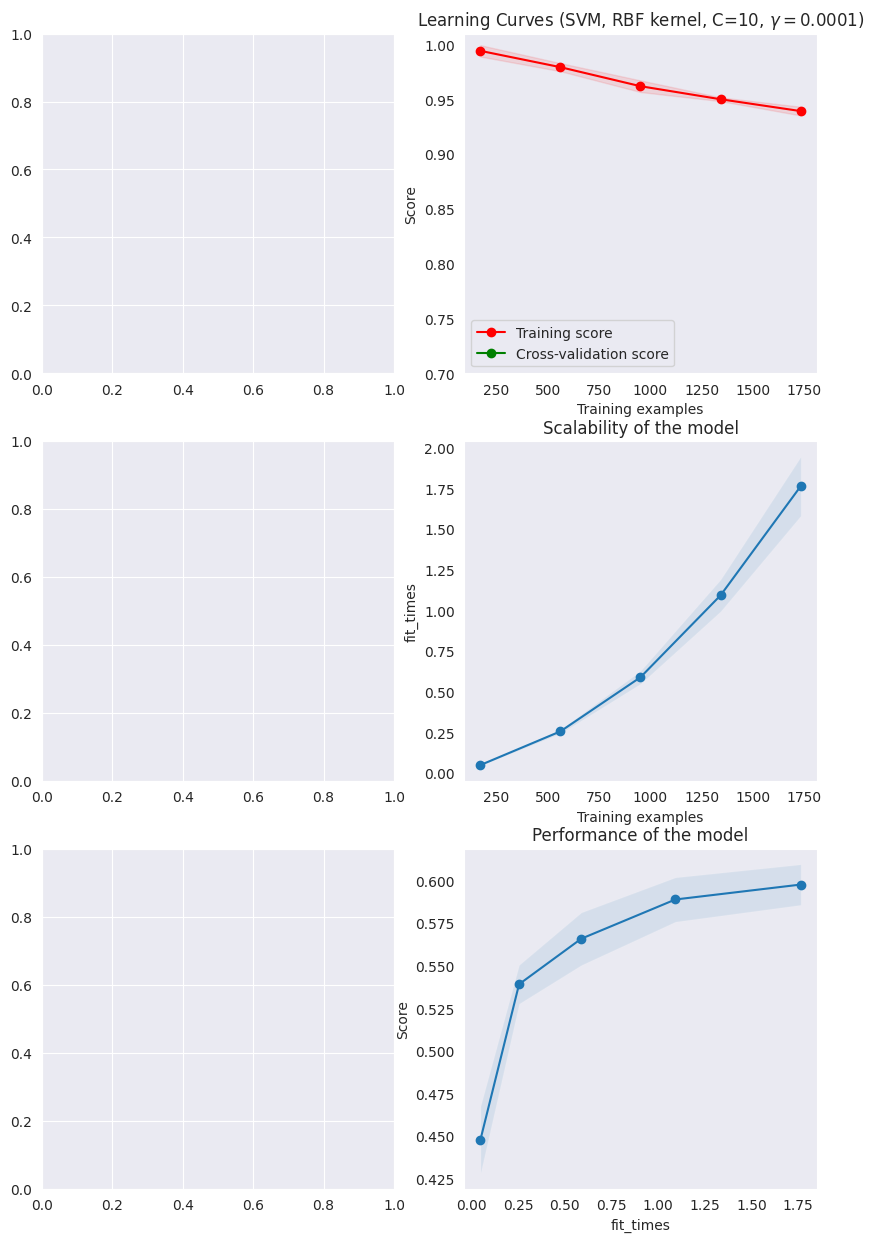

In [44]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = r"Learning Curves (SVM, RBF kernel, C=10, $\gamma=0.0001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = classifier
plot_learning_curve(
    estimator, title, X_train_scaled, y_train, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

plt.show()